# fig — ood (develop)

**Motivation**: host = ```mach```, device = ```cuda:0``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_IterativeVAE'))
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
from analysis.chosen import *
from figures.analysis import *
from analysis.ood import ood_analysis
from analysis.clf import LogisticRegression

device_idx = 0
device = f'cuda:{device_idx}'

print(f"device: {device}  ———  host: {os.uname().nodename}")

device: cuda:0  ———  host: mach

In [3]:
fig_base_dir = pjoin(fig_base_dir, 'iclr_oct02', 'ood')
os.makedirs(fig_base_dir, exist_ok=True)
print(os.listdir(fig_base_dir))

kws_fig = {
    'transparent': True,
    'bbox_inches': 'tight',
    'dpi': 300,
}

[
    'ood_src-EMNIST_tgt-EMNIST',
    'ood_src-EMNIST_tgt-MNIST',
    'ood_src-Omniglot_tgt-Omniglot',
    'ood_src-MNIST_tgt-Omniglot',
    'ood_src-MNIST_tgt-MNIST',
    'ood_src-Omniglot_tgt-EMNIST',
    'ood_src-EMNIST_tgt-Omniglot',
    'ood_src-Omniglot_tgt-MNIST',
    'ood_src-MNIST_tgt-EMNIST'
]

## VAE: amort and iterative

### iP-VAE

In [4]:
models_to_load = selected_models_28x28(device)
models_to_load = {
    m: d for m, d in
    models_to_load.items()
    if '<jacob|mlp>' in m  # no conv, no aiP-VAE
    # if 'mlp' in m  # no conv, include aiP-VAE
}
models_to_load = dict(sorted(
    models_to_load.items(),
    key=lambda t: alphanum_sort_key(t[0]),
))
print(list(models_to_load))

['EMNIST_<jacob|mlp>_(64,24.0)', 'MNIST_<jacob|mlp>_(64,24.0)', 'Omniglot_<jacob|mlp>_(64,24.0)']

In [5]:
trainers = {}
for model_name, kws_load in models_to_load.items():
    trainers[model_name] = load_model(**kws_load)[0]

In [6]:
datasets = [m.split('_')[0] for m in trainers]
print(datasets)

['EMNIST', 'MNIST', 'Omniglot']

In [7]:
inds = get_shuffle_inds()
print(inds)

assert set(inds) == set(datasets)

{
    'MNIST': array([ 0,  1,  2,  3,  4,  7,  8, 11, 18, 61]),
    'EMNIST': array([ 7347,  8015, 10273,  1094, 10720,  9523, 14948, 12968,  5956,
        4567]),
    'Omniglot': array([ 2375,  4316,  1579,  1236,  9005, 11172,   885,  6087, 10796,
        4771])
}

In [8]:
def _prep_fig():
    # make plots
    vld = make_dataset(ds_tgt)[1]
    x, g = vld.tensors

    src = tonp(x)[inds[ds_tgt]]
    recon = results['recon'][:, -1][inds[ds_tgt]]
    recon = recon.reshape(tr.model.cfg.shape)
    return src, recon


def _save_fig():
    fig_base_name = f"{analysis_name}_{model_name}"

    for row in [True, False]:
        row_col_str = 'row' if row else 'col'

        fig, ax = plot_row_or_col(src, row=row, display=False)
        fig_name = f"{fig_base_name}_{row_col_str}-input.png"
        fig_name = pjoin(fig_dir, fig_name)
        fig.savefig(fig_name, **kws_fig)
    
        fig, ax = plot_row_or_col(recon, row=row, display=False)
        fig_name = f"{fig_base_name}_{row_col_str}-recon.png"
        fig_name = pjoin(fig_dir, fig_name)
        fig.savefig(fig_name, **kws_fig)

100%|█████████████████████████████████| 14/14 [02:15<00:00,  9.66s/it]


______________________________________________________________________________________________________________

model: EMNIST_<jacob|mlp>_(64,24.0) ——— target: EMNIST
mse:    4.17
accuracy:       0.760

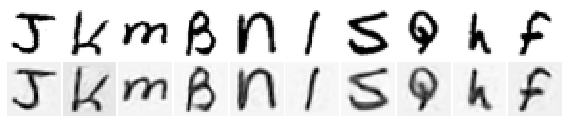

100%|███████████████████████████████████| 7/7 [00:59<00:00,  8.54s/it]


______________________________________________________________________________________________________________

model: EMNIST_<jacob|mlp>_(64,24.0) ——— target: MNIST
mse:    5.73
accuracy:       0.931

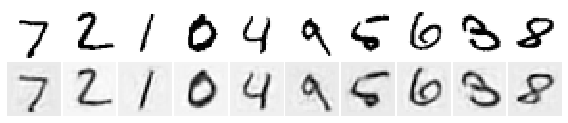

100%|███████████████████████████████████| 9/9 [01:21<00:00,  9.00s/it]


______________________________________________________________________________________________________________

model: EMNIST_<jacob|mlp>_(64,24.0) ——— target: Omniglot
mse:    18.55
accuracy:       0.001

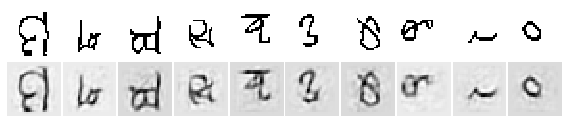

100%|█████████████████████████████████| 14/14 [02:10<00:00,  9.30s/it]


______________________________________________________________________________________________________________

model: MNIST_<jacob|mlp>_(64,24.0) ——— target: EMNIST
mse:    13.08
accuracy:       0.764

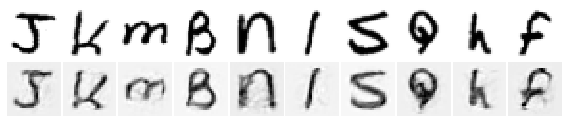

100%|███████████████████████████████████| 7/7 [01:03<00:00,  9.02s/it]


______________________________________________________________________________________________________________

model: MNIST_<jacob|mlp>_(64,24.0) ——— target: MNIST
mse:    3.97
accuracy:       0.958

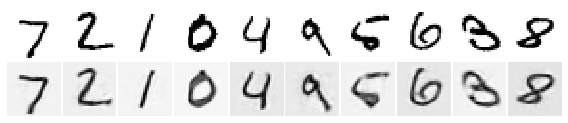

100%|███████████████████████████████████| 9/9 [01:23<00:00,  9.28s/it]


______________________________________________________________________________________________________________

model: MNIST_<jacob|mlp>_(64,24.0) ——— target: Omniglot
mse:    18.92
accuracy:       0.001

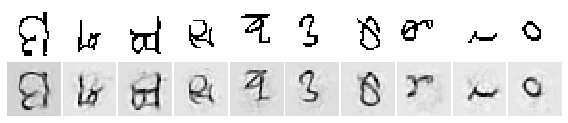

100%|█████████████████████████████████| 14/14 [02:13<00:00,  9.53s/it]


______________________________________________________________________________________________________________

model: Omniglot_<jacob|mlp>_(64,24.0) ——— target: EMNIST
mse:    12.48
accuracy:       0.727

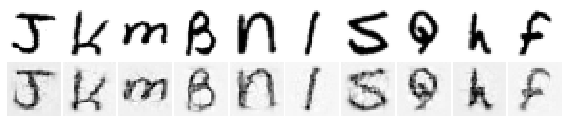

100%|███████████████████████████████████| 7/7 [01:00<00:00,  8.64s/it]


______________________________________________________________________________________________________________

model: Omniglot_<jacob|mlp>_(64,24.0) ——— target: MNIST
mse:    8.89
accuracy:       0.925

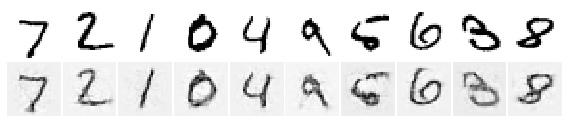

100%|███████████████████████████████████| 9/9 [01:27<00:00,  9.69s/it]


______________________________________________________________________________________________________________

model: Omniglot_<jacob|mlp>_(64,24.0) ——— target: Omniglot
mse:    9.75
accuracy:       0.001

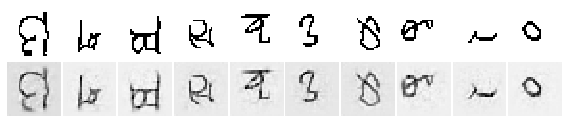

CPU times: user 36min 4s, sys: 7min 36s, total: 43min 40s
Wall time: 18min 57s


In [9]:
%%time


df = collections.defaultdict(list)
for model_name, tr in trainers.items():
    if tr.model.cfg.enc_type == 'jacob':
        is_ipvae = True
    else:
        is_ipvae = False

    tr.cfg.batch_size = 1500
    t_recon = 1000 if is_ipvae else -1

    ds_src = tr.model.cfg.dataset
    assert ds_src == model_name.split('_')[0]
    # ds_tgt_list = [ds for ds in datasets if ds != ds_src]

    for ds_tgt in datasets:
        analysis_name = f"ood_src-{ds_src}_tgt-{ds_tgt}"
        fig_dir = pjoin(fig_base_dir, analysis_name)
        os.makedirs(fig_dir, exist_ok=True)

        accuracy, results = ood_analysis(
            tr=tr,
            dataset=ds_tgt,
            n_data_batches=None,
            t_clf=-1,
            t_recon=t_recon,
            verbose=True,
        )
        
        print('_' * 110)
        msg = '\n'.join([
            f"model: {model_name} ——— target: {ds_tgt}",
            f"mse:\t{results['mse'][-1]:0.2f}",
            f"accuracy:\t{accuracy:0.3f}",
        ])
        print(msg)

        # save results
        df['analysis_name'].append(analysis_name)
        df['ds_src'].append(ds_src)
        df['ds_tgt'].append(ds_tgt)
        df['model'].append('iP-VAE' if is_ipvae else 'aiP-VAE')
        df['enc_type'].append(tr.model.cfg.enc_type)
        df['dec_type'].append(tr.model.cfg.dec_type)
        df['n_iters_train'].append(tr.model.cfg.seq_len)
        df['n_iters_test'].append(results['props']['t_recon'])
        df['mse'].append(results['mse'][-1])
        df['accuracy'].append(accuracy)

        src, recon = _prep_fig()
        _save_fig()

        # show fig (for sanity check only)
        x2p = np.concatenate([src, recon])
        _ = plot_weights(
            x2p, nrows=2, cmap='Greys',
            vmin=0.001, vmax=1, dpi=70,
        )
        print('\n\n')

In [11]:
# df = pd.DataFrame(df)

# save_obj(
#     obj=df,
#     file_name='df_ood',
#     save_dir=tmp_dir,
#     mode='df',
# )

[PROGRESS] 'df_ood.df' saved at
/home/hadi/Dropbox/git/jb-vae/tmp

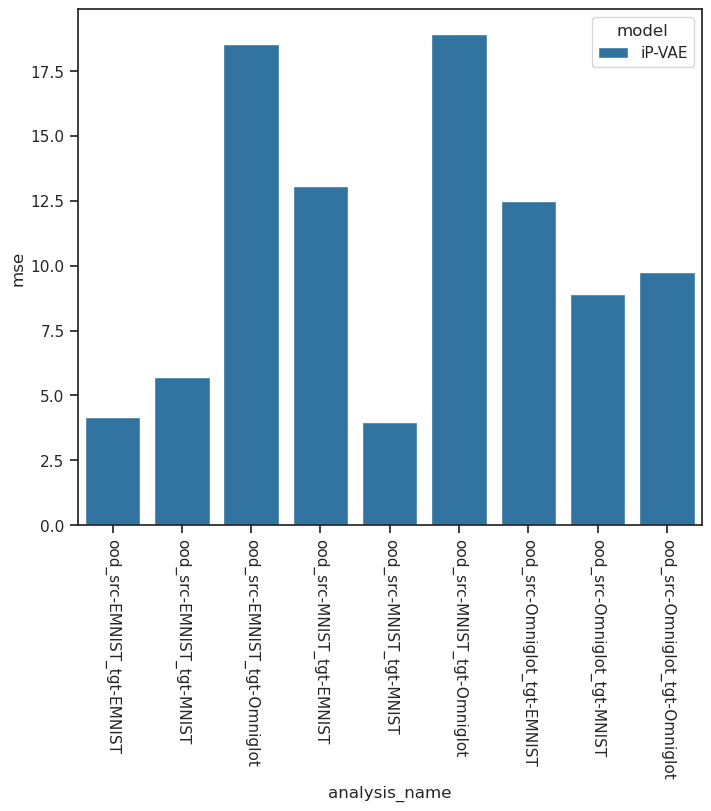

In [11]:
fig, ax= create_figure(1, 1, (7, 8))
sns.barplot(data=pd.DataFrame(df), x='analysis_name', y='mse', hue='model', ax=ax)
ax.tick_params(axis='x', rotation=-90)

## OOD: Marino & Kim

In [4]:
def _extract_src_tgt(name):
    def _final_processing(s):
        s = str(s)
        if s.lower == 'omniglot':
            s = s.capitalize()
        else:
            s = s.upper()
        return s

    if '~' not in name:
        name = '~'.join(f.split('_')[:-1])
    from_to_part = [
        part for part in name.split('~')
        if 'from-' in part
    ][0]
    ds_src = from_to_part.split('-')[1]
    ds_tgt = from_to_part.split('-')[3]
    ds_src, ds_tgt = map(
        _final_processing,
        [ds_src, ds_tgt],
    )
    return ds_src, ds_tgt


def _extract_model_type(name):
    mapping = {
        'SAVAE': 'sa-VAE',
        'MARINO-single': 'ia-VAE (single-level)',
        'MARINO-hier': 'ia-VAE (hierarchical)'
    }
    if '~' not in name:
        name = '~'.join(f.split('_')[:-1])
    model = name.split('~')[0]
    if 'hierarchical' in name:
        model = f"{model}-hier"
    elif 'single' in name:
        model = f"{model}-single"
    elif model == 'SAVAE':
        pass
    else:
        raise ValueError(name)

    model = mapping[model]
    return model

In [4]:
dekel_dir = '/home/hadi/Dropbox/git/jb-vae/tmp/dekel_data/rot_full'

dekel_files = sorted(
    os.listdir(dekel_dir),
    key=alphanum_sort_key,
)
across_files = [
    f for f in dekel_files
    if '_from' in f
]
within_files = [
    f for f in dekel_files
    if 'rotate' not in f
    and 'from' not in f
    and '_vh_' not in f
]
selected_dekel_files = sorted(
    across_files + within_files,
    key=alphanum_sort_key,
)
print(selected_dekel_files)

[
    'MARINO_emnist_hierarchical_iterative_EMNIST_H_10_full.npz',
    'MARINO_emnist_single_level_iterative_EMNIST_SL_10_full.npz',
    'MARINO_hierarchical_from-emnist-to-mnist_EMNIST_H_iters10_full.npz',
    'MARINO_hierarchical_from-emnist-to-omniglot_EMNIST_H_iters10_full.npz',
    'MARINO_hierarchical_from-mnist-to-emnist_MNIST_H_iters10_full.npz',
    'MARINO_hierarchical_from-mnist-to-omniglot_MNIST_H_iters10_full.npz',
    'MARINO_hierarchical_from-mnist-to-omniglot_MNIST_H_iters1000_full.npz',
    'MARINO_hierarchical_from-omniglot-to-emnist_OMNIGLOT_HADI_H_iters10_full.npz',
    'MARINO_hierarchical_from-omniglot-to-mnist_OMNIGLOT_HADI_H_iters10_full.npz',
    'MARINO_mnist_hierarchical_iterative_MNIST_H_10_full.npz',
    'MARINO_mnist_single_level_iterative_MNIST_SL_10_full.npz',
    'MARINO_omniglot-hadi_hierarchical_iterative_OMNIGLOT_HADI_H_10_full.npz',
    'MARINO_omniglot-hadi_single_level_iterative_OMNIGLOT_HADI_SL_10_full.npz',
    'MARINO_single_level_from-emnist-to-mnist_EMNIST_SL_iters10_full.npz',
    'MARINO_single_level_from-emnist-to-omniglot_EMNIST_SL_iters10_full.npz',
    'MARINO_single_level_from-mnist-to-emnist_MNIST_SL_iters10_full.npz',
    'MARINO_single_level_from-mnist-to-omniglot_MNIST_SL_iters10_full.npz',
    'MARINO_single_level_from-omniglot-to-emnist_OMNIGLOT_HADI_SL_iters10_full.npz',
    'MARINO_single_level_from-omniglot-to-mnist_OMNIGLOT_HADI_SL_iters10_full.npz',
    'SAVAE_emnist_iter20_full.npz',
    'SAVAE_from-emnist-to-mnist_iter20_full.npz',
    'SAVAE_from-emnist-to-omniglot_iter20_full.npz',
    'SAVAE_from-mnist-to-emnist_iter20_full.npz',
    'SAVAE_from-mnist-to-omniglot_iter20_full.npz',
    'SAVAE_from-omniglot-to-emnist_iter20_full.npz',
    'SAVAE_from-omniglot-to-mnist_iter20_full.npz',
    'SAVAE_mnist_iter20_full.npz',
    'SAVAE_omniglot_iter20_full.npz'
]

In [23]:
for f in across_files:
    name = '~'.join(f.split('_')[:-1])
    load = dict(np.load(
        pjoin(dekel_dir, f),
        allow_pickle=True,
    ))

    ds_src, ds_tgt = _extract_src_tgt(name)
    model_name = _extract_model_type(name)
    
    component = f"from-{ds_src}-to-{ds_tgt}".lower()
    assert component in name.lower()

    print(load['recons_val'].shape)

(10000, 1, 28, 28)

(13180, 28, 28, 1)

(20800, 28, 28, 1)

(13180, 28, 28, 1)

(20800, 1, 28, 28)

(10000, 1, 28, 28)

(10000, 1, 28, 28)

(13180, 28, 28, 1)

(20800, 28, 28, 1)

(13180, 28, 28, 1)

(20800, 1, 28, 28)

(10000, 1, 28, 28)

(10000, 1, 28, 28)

(13180, 1, 28, 28)

(20800, 1, 28, 28)

(13180, 1, 28, 28)

(20800, 1, 28, 28)

(10000, 1, 28, 28)

'sa-VAE'

In [46]:
for f in within_files:
    model_name = '~'.join(f.split('_')[:-1])
    load = dict(np.load(
        pjoin(dekel_dir, f),
        allow_pickle=True,
    ))
    model, dataset = _extract_from_within(f)
    n_iters = int_from_str(model_name.split('~')[-1])
    print(model_name, n_iters)

MARINO~emnist~hierarchical~iterative~EMNIST~H~10 10

MARINO~emnist~single~level~iterative~EMNIST~SL~10 10

MARINO~mnist~hierarchical~iterative~MNIST~H~10 10

MARINO~mnist~single~level~iterative~MNIST~SL~10 10

MARINO~omniglot-hadi~hierarchical~iterative~OMNIGLOT~HADI~H~10 10

MARINO~omniglot-hadi~single~level~iterative~OMNIGLOT~HADI~SL~10 10

SAVAE~emnist~iter20 20

SAVAE~mnist~iter20 20

SAVAE~omniglot~iter20 20

In [30]:
model_name

'SAVAE~omniglot~iter20'

In [44]:
print(within_files)

[
    'MARINO_emnist_hierarchical_iterative_EMNIST_H_10_full.npz',
    'MARINO_emnist_single_level_iterative_EMNIST_SL_10_full.npz',
    'MARINO_mnist_hierarchical_iterative_MNIST_H_10_full.npz',
    'MARINO_mnist_single_level_iterative_MNIST_SL_10_full.npz',
    'MARINO_omniglot-hadi_hierarchical_iterative_OMNIGLOT_HADI_H_10_full.npz',
    'MARINO_omniglot-hadi_single_level_iterative_OMNIGLOT_HADI_SL_10_full.npz',
    'SAVAE_emnist_iter20_full.npz',
    'SAVAE_mnist_iter20_full.npz',
    'SAVAE_omniglot_iter20_full.npz'
]

In [7]:
f = 'MARINO_omniglot-hadi_single_level_iterative_OMNIGLOT_HADI_SL_10_full.npz'

In [8]:
mrsl = dict(np.load(
    pjoin(dekel_dir, f),
    allow_pickle=True,
))

In [9]:
mrsl["recons_val"].shape

(13180, 28, 28, 1)

In [20]:
vld = make_dataset('Omniglot')[1]
vld = tonp(vld.tensors[0])

In [22]:
((mrsl["recons_val"][...,0][inds_dekel]/255- vld[:, 0])**2).mean(0).sum()

21.261284

In [16]:
vld.shape

(13180, 1, 28, 28)

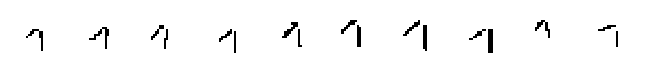

In [17]:
_ = plot_row_or_col(vld[:10], display=True)

In [ ]:
a = vld[:, 0].reshape(13180, -1)
b = (mrsl["recons_val"][...,0]/255).reshape(13180, -1)

In [ ]:
sim = 1 - c

In [75]:
a.shape, b.shape, c.shape

((13180, 784), (13180, 784), (100, 100))

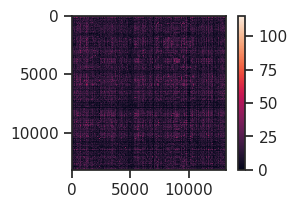

In [69]:
plt.imshow(c)
plt.colorbar()

In [ ]:
((mrsl["recons_val"][...,0]/255- vld[:, 0]/255)**2).mean(0).sum()

93.06395

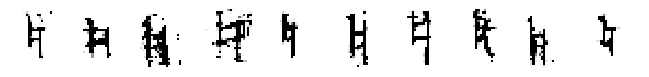

In [66]:
_ = plot_row_or_col(mrsl["recons_val"][...,0][:10] / 10, display=True)

In [ ]:
_ = plot_row_or_col(mrsl["recons_val"][...,0][:10] / 10, display=True)

<Axes: ylabel='Count'>

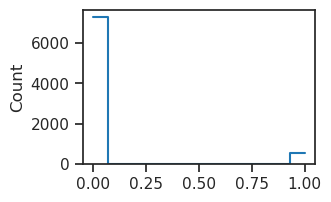

In [59]:
histplot(vld[:10].ravel())

In [12]:
name

'SAVAE~from-omniglot-to-mnist~iter20'

In [13]:
list(load)

['recons_trn',
 'recons_val',
 'posteriors_trn',
 'posteriors_val',
 'model_n_params']

In [29]:
trn, vld, _ = make_dataset(ds_tgt)
src, g_vld = vld.tensors
g_trn = trn.tensors[1]

g_trn, g_vld = map(
    lambda g: tonp(g).astype(int),
    [g_trn, g_vld],
)

In [30]:
recon = load['recons_val']
if np.nanmax(recon) > 1:
    recon /= 255
mse = (tonp(src) - load['recons_val']) ** 2
mse = mse.sum(axis=(1, 2, 3)).mean(0)

z_vld = load['posteriors_val'][:, 0, 0]
z_trn = load['posteriors_trn'][:, 0, 0]
clf = LogisticRegression().fit(z_trn, g_trn)
accuracy = (clf.predict(z_vld) == g_vld).mean()

In [31]:
accuracy, mse

(0.9093, 13.585813)

In [32]:
src = src[inds[ds_tgt]]
recon = recon[inds[ds_tgt]]
x2p = np.concatenate([src, recon])

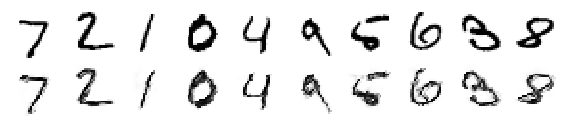

In [36]:
_ = plot_weights(
    x2p, nrows=2, cmap='Greys',
    vmin=0.001, vmax=1, dpi=70,
)

In [18]:
(name)

'SAVAE~from-omniglot-to-mnist~iter20'